In [1]:
# Loading all needed packages at the start
import elastix
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np
import shutil

## **Fill in your own paths in the cell**




In [2]:
# to Elastix.exe
ELASTIX_PATH=r"C:\Users\20191679\Documents\Master\CS_image_analysis\elastix.exe"
el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)

# to Transformix.exe
TRANSFORMIX_PATH=r"C:\Users\20191679\Documents\Master\CS_image_analysis\transformix.exe"

# to Training Data
filepath_data = r"C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData"


### Load patient data and visualize the images


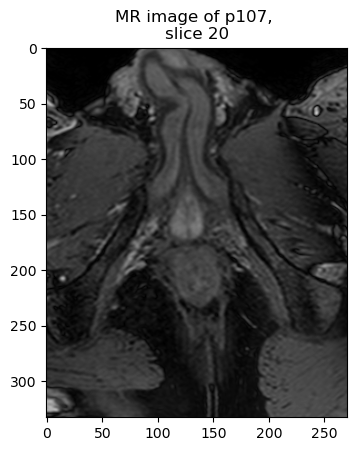

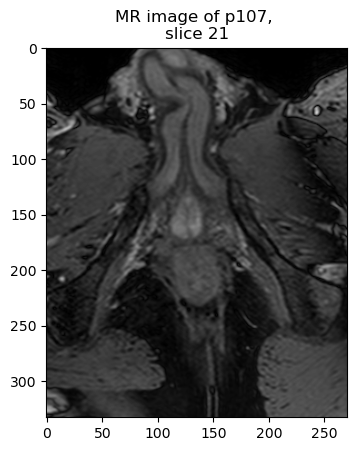

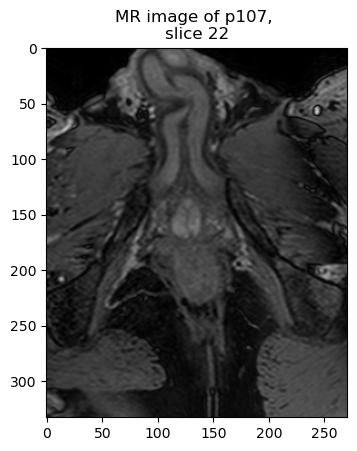

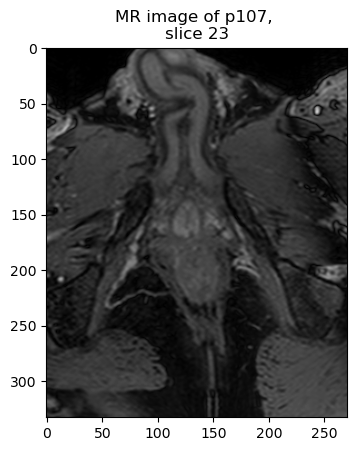

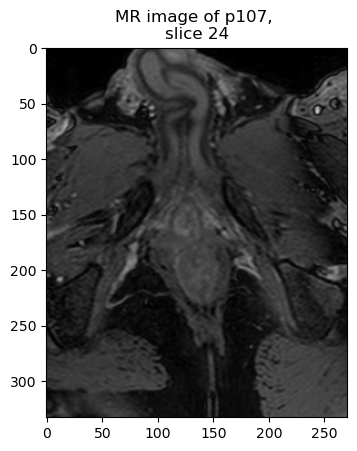

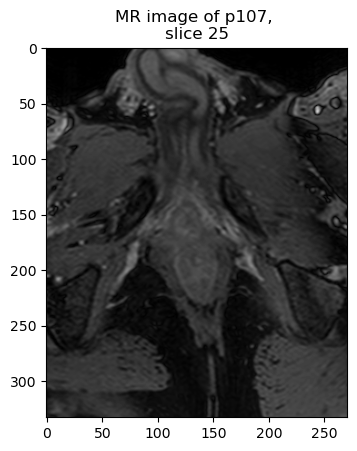

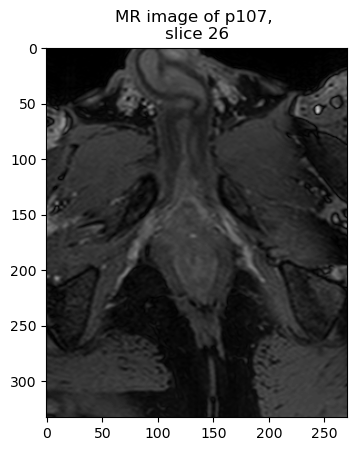

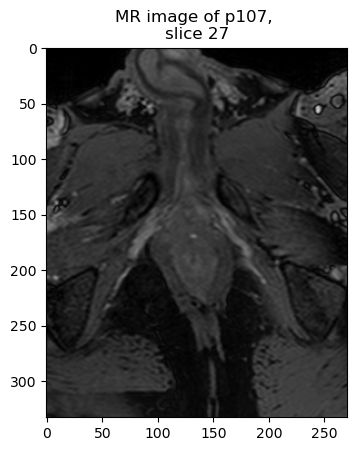

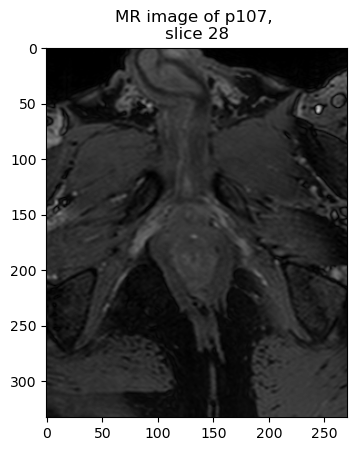

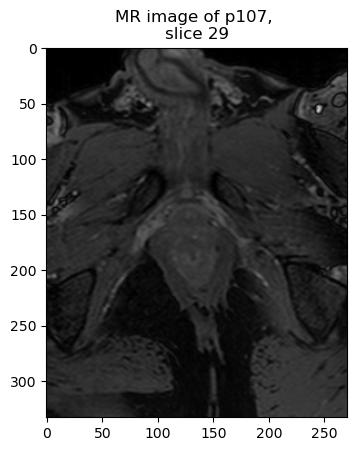

In [3]:
patient_nrs_list = ['p102','p107', 'p108', 'p109', 'p115', 'p116', 'p117', 
                    'p119', 'p120', 'p125', 'p127','p128', 'p129', 'p133', 'p135']

patient_nr = patient_nrs_list[1] 
file_p_mr = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_nr)  
file_p_mask = filepath_data+'\{}\prostaat.mhd'.format(patient_nr) 


readable_mr = imageio.imread(file_p_mr)
readable_mask = imageio.imread(file_p_mask)

for i in range(20,30):
    plt.imshow(readable_mr[i,:,:], cmap="gray") 
    plt.imshow(readable_mask[i,:,:], cmap="gray", alpha =0.2) 
    
    plt.title('MR image of {}, \nslice {}'.format(patient_nr,i))
    plt.show()

## Preparation before transformation


In [4]:
# instead of manually adjusting the fixed and moving patient,
# this should be linked to the script of MI in an automatic way
# register these two patients 
patient_fixed= patient_nrs_list[0] 
patient_moving= patient_nrs_list[1] 

# instead of manually adjusting the slice of the fixed image,
# this should be linked to the script of MI in an automatic way
# determine the slice of the fixed image
slice_fixed = 50
#we also need to think if we want to give one moving slice each time, or 5 slices at a time, because it will be more difficult
#to match this slice with the right moving patient. Depends on the output we get from the MI script
slice_moving = 56


In [5]:
def visualize_patients(patient_fixed, patient_moving, slice_fixed, slice_moving):
    """
    Visually inspect the slices of the fixed and moving patient
    
    input:
    patient_fixed: patient number of fixed patient (e.g. p107)
    patient_moving: patient number of fixed patient (e.g. p108)
    slice_fixed: slice number of fixed slice
    slice_moving: slice number of moving slice
    
    output:
    plots of fixed and moving slice
    """

    fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_fixed)
    moving_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_moving)

    readable_fixed = imageio.imread(fixed_image_path)
    readable_moving = imageio.imread(moving_image_path)

    # visualize the images
    plt.imshow(readable_fixed[slice_fixed,:,:], cmap='gray') 
    plt.title('Fixed MR input image, \nslice {}, {}'.format(slice_fixed, patient_fixed))
    plt.show()

    # instead of manually adjusting this range, this should be the range of the moving slices
    plt.imshow(readable_moving[slice_moving,:,:], cmap='gray') 
    plt.title('Moving MR input image, \nslice {}, {}'.format(slice_moving, patient_moving))


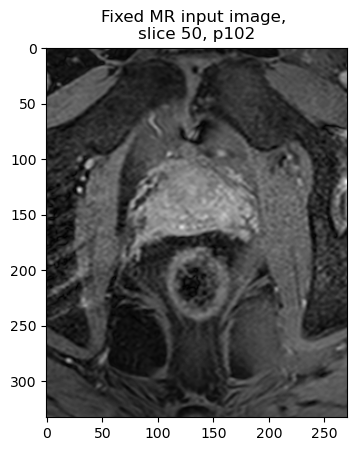

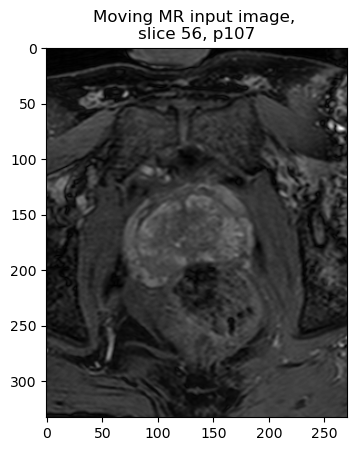

In [6]:
visualize_patients(patient_fixed,patient_moving,slice_fixed,slice_moving)

In [7]:
def create2DImages(fixed_image_path, moving_image_path):
    """
    Create a 2D image of each slice in the 3D image.
    
    input: 
    fixed_image_path: the path to the fixed image slice. 
    moving_image_path: the path to the moving image slices.
    
    output:
    - 
    
    """
    itk_image_fixed = sitk.ReadImage(fixed_image_path)
    itk_image_moving = sitk.ReadImage(moving_image_path)
    
    # I kept the for-loop since one patient always contains 86 slices and it is so fast that I don't think it is necessary
    # to only create images for certain slices
    for i in range(86): 
        # fixed image
        itk_img_array = sitk.GetArrayFromImage(itk_image_fixed)
        slice = sitk.GetImageFromArray(itk_img_array[i,:,:])
        path_fixed = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_fixed, patient_fixed, i)
        sitk.WriteImage(slice,path_fixed)
    
        # moving image
        itk_img_array_moving = sitk.GetArrayFromImage(itk_image_moving)
        slice = sitk.GetImageFromArray(itk_img_array_moving[i,:,:])
        path_moving = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
        sitk.WriteImage(slice,path_moving)
        


In [8]:
fixed_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_fixed)
moving_image_path = filepath_data+ '\{}\mr_bffe.mhd'.format(patient_moving)

create2DImages(fixed_image_path, moving_image_path)

# B SPLINES TRANSFORMATION


In [9]:
def bspline_registration(patient_fixed, patient_moving, slice_fixed, slice_moving, 
                         parameter_file_bsplines=os.path.join(filepath_data,'parameters_penalty.txt') ):
    """
    Performs bspline transformation
    
    input:
    - patient_fixed: patient number of fixed patient (e.g. p107)
    - patient_moving: patient number of fixed patient (e.g. p108)
    - slice_fixed: slice number of fixed slice
    - slice_moving: slice number of moving slice
    - parameter_file_bsplines: parameter file needed for bspline transformation, default value: parameters_penalty
    
    output:
    -
    """
    path_fixed = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)
    path_moving = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_moving, patient_moving, slice_moving)
    
    # create a folder to store the results files
    if not os.path.exists(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving))):
        os.makedirs(os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving))))
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving)))
    

    # apply the bspline transformation
    el.register(
    fixed_image=path_fixed,
    moving_image=path_moving,  
    parameters=[parameter_file_bsplines],
    output_dir=output_file_path_bspline)
    

In [10]:
bspline_registration(patient_fixed, patient_moving, slice_fixed, slice_moving)

C:\Users\20191679\Documents\Master\CS_image_analysis\elastix.exe -f C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\p102_slice50.mhd -m C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p107\p107_slice56.mhd -p C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\parameters_penalty.txt -out C:\Users\20191679\Documents\Master\CS_image_analysis\TrainingData\p102\bspline_results_slice_50\moving_slice_p107_56


In [11]:
def visualize_bspline_results(patient_fixed, patient_moving, slice_fixed, slice_moving):
    """
    Visualize results of bspline transformation
    
    input:
     - patient_fixed: patient number of fixed patient (e.g. p107)
    - patient_moving: patient number of fixed patient (e.g. p108)
    - slice_fixed: slice number of fixed slice
    - slice_moving: slice number of moving slice
    
    output:
    3 images displayed the fixed slice, moving slice and transformed moving slice
    """
    
    # currently it says slice_fixed, but this should be changed accordingly when it is combined with MI script
    # define the path to the slice of the fixed image
    path_fixed = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)

    # define the path to the slice of the moving image
    path_moving = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_moving, patient_moving, slice_moving)
    
    # create a folder to store the results files
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving)))
    
    # visualize the images  
    itk_image_fixed = sitk.ReadImage(path_fixed)
    image_array_fixed = sitk.GetArrayFromImage(itk_image_fixed)
    
    itk_image_moving = sitk.ReadImage(path_moving)
    image_array_moving = sitk.GetArrayFromImage(itk_image_moving)
    
    result_path_bspline = os.path.join(output_file_path_bspline, 'result.0.mhd')   
    transformed_moving_image = imageio.imread(result_path_bspline)  
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(image_array_fixed[:,:], cmap='gray')
    ax[1].imshow(image_array_moving[:,:], cmap='gray')
    ax[2].imshow(transformed_moving_image[:,:], cmap='gray')

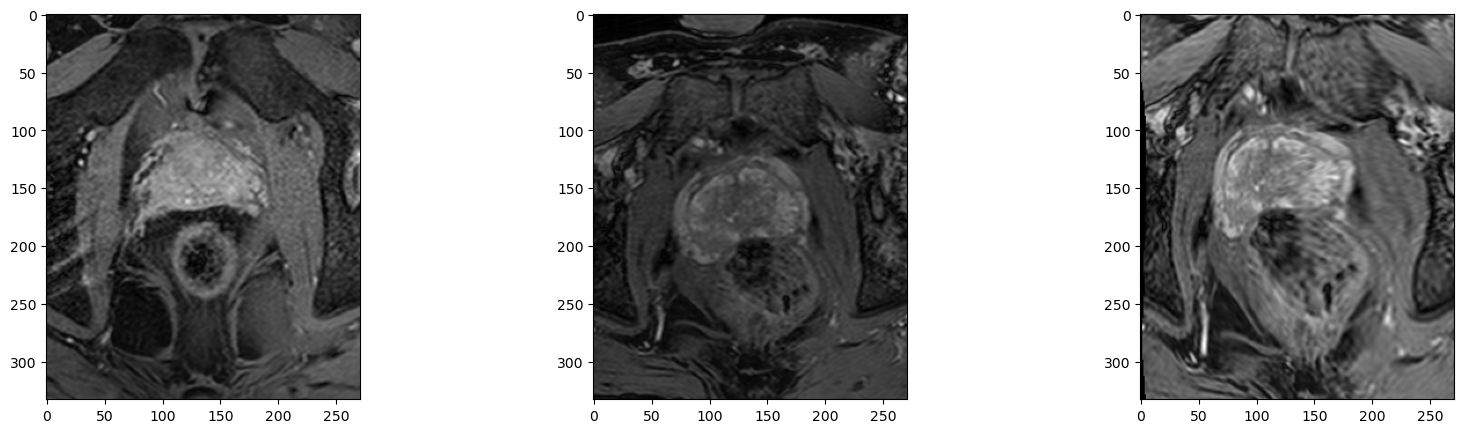

In [12]:
visualize_bspline_results(patient_fixed, patient_moving, slice_fixed, slice_moving)

### JACOBIAN

In [13]:

def Jacobian(output_file_path_bspline):
    """
    Calculate the Jacobian.
    
    input:
    output_file_path_bspline: the path to the TransformParameters.0.txt file.
    
    output:
    imb: the Jacobian value.
    
    """
    # define the path to the transform parameters file
    transform_path_im = os.path.join(output_file_path_bspline,'TransformParameters.0.txt')
    
    # apply transformix
    tr = elastix.TransformixInterface(parameters=transform_path_im,
                                  transformix_path=TRANSFORMIX_PATH)
    
    # define the path to the output folder
    output_dir_jacobian = output_file_path_bspline
    jacobian_matrix_path = tr.jacobian_matrix(output_dir=output_dir_jacobian)
    
    # Get the Jacobian determinant
    jacobian_determinant_path = tr.jacobian_determinant(output_dir=output_dir_jacobian)
    
    # Get the full deformation field
    deformation_field_path = tr.deformation_field(output_dir=output_dir_jacobian)
    imb = imageio.imread(jacobian_determinant_path,level=0)
    
    return imb
    


In [14]:
def visualize_jacobian(patient_fixed, patient_moving, slice_fixed, slice_moving):
    """
    Visualizes jacobian determinant of transformation
    
    input:
    - patient_fixed: patient number of fixed patient (e.g. p107)
    - patient_moving: patient number of fixed patient (e.g. p108)
    - slice_fixed: slice number of fixed slice
    - slice_moving: slice number of moving slice
    
    output:
    - image of jacobian determinant in transformed image
    """
    
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving)))
    
    # calculate the Jacobian per slice
    imb_value = Jacobian(output_file_path_bspline)
    
    # visualize the Jacobian per slice
    plt.figure(figsize=(5,5))
    pos = plt.imshow(imb_value[:,:],cmap='gray')
    plt.colorbar(pos)

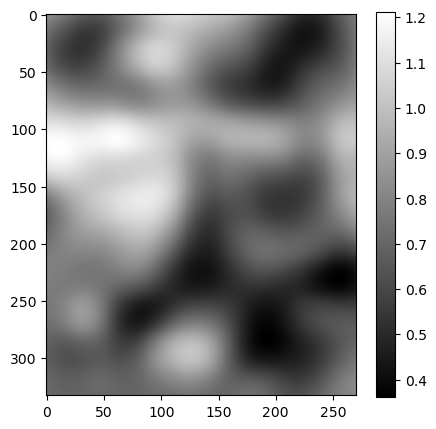

In [15]:
visualize_jacobian(patient_fixed, patient_moving, slice_fixed, slice_moving)

# Use transform matrix to get the corresponding masks

## Apply b-spline transformation to the masks

In [16]:
def create2DMasks(fixed_mask_path, moving_mask_path):
    """
    Create a 2D mask of each slice in the 3D mask.
    
    input: 
    fixed_mask_path: the path to the fixed mask slice. 
    moving_mask_path: the path to the moving mask slices.
    
    output:
    - 
    
    """
    itk_image_fixed = sitk.ReadImage(fixed_mask_path)
    itk_image_moving = sitk.ReadImage(moving_mask_path)
    
    # I kept the for-loop since one patient always contains 86 slices and it is so fast that I don't think it is necessary
    # to only create masks for certain slices
    for i in range(86): 
        # fixed mask
        itk_img_array = sitk.GetArrayFromImage(itk_image_fixed)
        slice = sitk.GetImageFromArray(itk_img_array[i,:,:])
        path_fixed = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, i)
        sitk.WriteImage(slice,path_fixed)
    
        # moving image
        itk_img_array_moving = sitk.GetArrayFromImage(itk_image_moving)
        slice = sitk.GetImageFromArray(itk_img_array_moving[i,:,:])
        path_moving = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, i)
        sitk.WriteImage(slice,path_moving)



In [17]:
fixed_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_fixed)
moving_mask_path = filepath_data+ '\{}\prostaat.mhd'.format(patient_moving)

create2DMasks(fixed_mask_path, moving_mask_path)

In [18]:
def newTransformParameterFile(patient_fixed, patient_moving, slice_fixed, slice_moving):
    """
    Create a copy of the 'TransformParameters.0.txt' and rename it to 'TransformParameters.0b.txt'.
    In the new file, the (FinalBSplineInterpolationOrder 3) is changed to value 0.
    
    input:
    - patient_fixed: patient number of fixed patient (e.g. p107)
    - patient_moving: patient number of fixed patient (e.g. p108)
    - slice_fixed: slice number of fixed slice
    - slice_moving: slice number of moving slice
    
    output:
    - 
    
    """
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving)))
    # define the path to the transform parameters file
    transform_path = os.path.join(output_file_path_bspline,'TransformParameters.0.txt')
    
    # create a copy of the file and rename it
    target_path = os.path.join(output_file_path_bspline,'TransformParameters.0b.txt')
    shutil.copyfile(transform_path, target_path)
    
    # change the value from 3 to 0
    with open(target_path,'r') as file:
        data=file.read()
        data=data.replace("(FinalBSplineInterpolationOrder 3)", "(FinalBSplineInterpolationOrder 0)")
        
    with open(target_path,'w') as file:
        
        file.write(data)


In [19]:
newTransformParameterFile(patient_fixed, patient_moving, slice_fixed, slice_moving)

In [20]:
def bspline_mask_registration(patient_fixed, patient_moving, slice_fixed, slice_moving):
    """
    Performs bspline transformation on masks, using the parameter file from the earlier registration
    
    input: 
    - patient_fixed: patient number of fixed patient (e.g. p107)
    - patient_moving: patient number of fixed patient (e.g. p108)
    - slice_fixed: slice number of fixed slice
    - slice_moving: slice number of moving slice
    
    output:
    -
    """

    # define the path to the slice of the fixed mask
    path_fixed_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)

    # define the path to the slice of the moving mask
    path_moving_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, slice_moving)
    
    # define the path to the transform parameters file
    output_file_path_bspline = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving)))
    target_path = os.path.join(output_file_path_bspline,'TransformParameters.0b.txt')
    
    # create a folder to store the results files    
    if not os.path.exists(os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving))):
        os.makedirs(os.path.join(os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving))))
    output_file_path_bspline_mask = os.path.join(os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving)))
    
    # apply transformix
    tr = elastix.TransformixInterface(parameters=target_path,
                                  transformix_path=TRANSFORMIX_PATH)
    
    # transform the moving mask with the transformation parameters
    tr.transform_image(path_moving_mask, output_dir=output_file_path_bspline_mask)
    


In [21]:
bspline_mask_registration(patient_fixed, patient_moving, slice_fixed, slice_moving)

In [22]:
def visualize_bspline_mask_results(patient_fixed, patient_moving, slice_fixed, slice_moving):
    """
    Visualizes results from bspline registration on the masks:
    
    input:
    - patient_fixed: patient number of fixed patient (e.g. p107)
    - patient_moving: patient number of fixed patient (e.g. p108)
    - slice_fixed: slice number of fixed slice
    - slice_moving: slice number of moving slice
    
    output:
    - Fixed image mask, moving image mask and transformed moving image mask
    """


    # define the path to the slice of the fixed mask
    path_fixed_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)

    # define the path to the slice of the moving mask
    path_moving_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, slice_moving)
    
    
    output_file_path_bspline_mask = os.path.join(os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving)))
    
    # visualize the images  
    itk_image_fixed = sitk.ReadImage(path_fixed_mask)
    image_array_fixed = sitk.GetArrayFromImage(itk_image_fixed)
    
    itk_image_moving = sitk.ReadImage(path_moving_mask)
    image_array_moving = sitk.GetArrayFromImage(itk_image_moving)
    
    result_path_bspline_mask = os.path.join(output_file_path_bspline_mask, 'result.mhd')
    transformed_moving_image = imageio.imread(result_path_bspline_mask)
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    ax[0].imshow(image_array_fixed[:,:], cmap='gray')
    ax[1].imshow(image_array_moving[:,:], cmap='gray')
    ax[2].imshow(transformed_moving_image[:,:], cmap='gray')

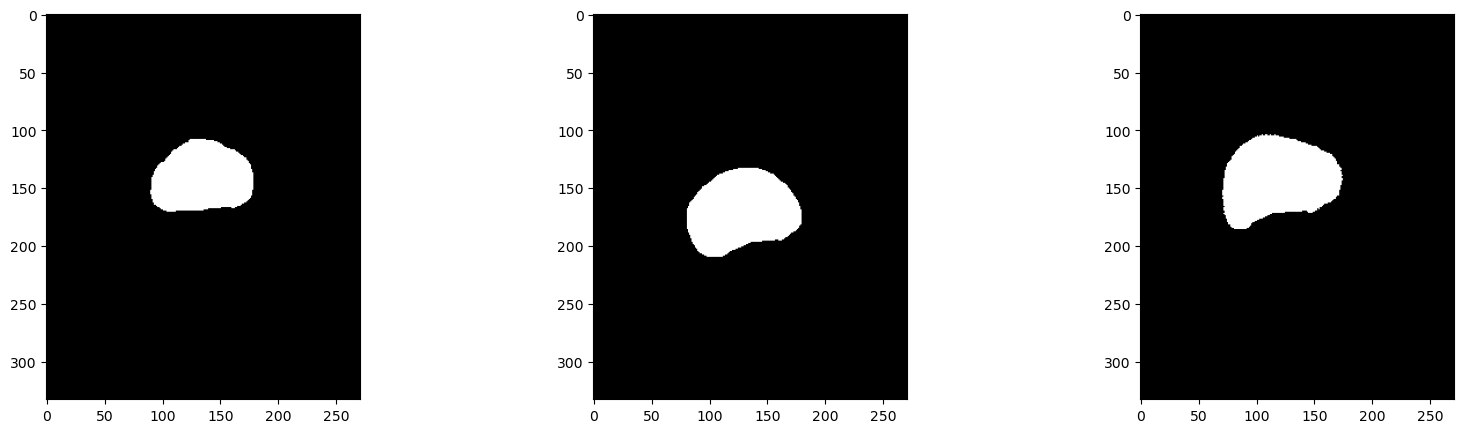

In [23]:
visualize_bspline_mask_results(patient_fixed, patient_moving, slice_fixed, slice_moving)

## Visualize the masks over the images

In [24]:
def overlay_mask(patient_fixed, patient_moving, slice_fixed, slice_moving):
    """
    Visualizes registration by overlaying the mask over the MR images
    
    input:
    - patient_fixed: patient number of fixed patient (e.g. p107)
    - patient_moving: patient number of fixed patient (e.g. p108)
    - slice_fixed: slice number of fixed slice
    - slice_moving: slice number of moving slice
    
    output:
    - Fixed, moving and transformed moving slice with masks overlayed
    """
    
    # define the path to the slice of the fixed image and mask
    path_fixed_IM = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)
    path_fixed_MASK = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)

    # define the path to the slice of the moving image
    path_moving_IM = filepath_data+ '\{}\{}_slice{}.mhd'.format(patient_moving, patient_moving, slice_moving)
    output_file_path_IM = os.path.join(os.path.join(filepath_data,'{}\\bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving)))   
    result_path_IM = os.path.join(output_file_path_IM, 'result.0.mhd')
    
    # define the path to the slice of the moving mask
    path_moving_MASK = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, slice_moving)
    output_file_path_MASK = os.path.join(filepath_data,'{}\\mask_bspline_results_slice_{}\\moving_slice_{}_{}'.format(patient_fixed,slice_fixed,patient_moving,slice_moving))
    result_path_MASK = os.path.join(output_file_path_MASK, 'result.mhd')
    
    # read the images
    readable_fixed_image_path_IM = imageio.imread(path_fixed_IM)
    readable_moving_image_path_IM = imageio.imread(path_moving_IM)
    transformed_moving_image_IM = imageio.imread(result_path_IM)
    
    # read the masks
    itk_image_fixed = sitk.ReadImage(path_fixed_MASK)
    image_array_fixed = sitk.GetArrayFromImage(itk_image_fixed)
    
    itk_image_moving = sitk.ReadImage(path_moving_MASK)
    image_array_moving = sitk.GetArrayFromImage(itk_image_moving)
    
    transformed_moving_image_MASK = imageio.imread(result_path_MASK)
    
    # visualize the images
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    ax[0].imshow(readable_fixed_image_path_IM[:,:], cmap='gray')
    ax[0].imshow(image_array_fixed[:,:], cmap='gray', alpha=0.5)
    ax[0].set_title('Fixed image, \nslice {}, {}'.format(i, patient_fixed))
    
    ax[1].imshow(readable_moving_image_path_IM[:,:], cmap='gray')
    ax[1].imshow(image_array_moving[:,:], cmap='gray', alpha=0.5)
    ax[1].set_title('Moving image, \nslice {}, {}'.format(i, patient_moving))
    
    ax[2].imshow(transformed_moving_image_IM[:,:], cmap='gray')
    ax[2].imshow(transformed_moving_image_MASK[:,:], cmap='gray', alpha=0.5)
    ax[2].set_title('Transformed\nmoving image, \nslice {}, {}'.format(i, patient_moving))
    
    plt.show()

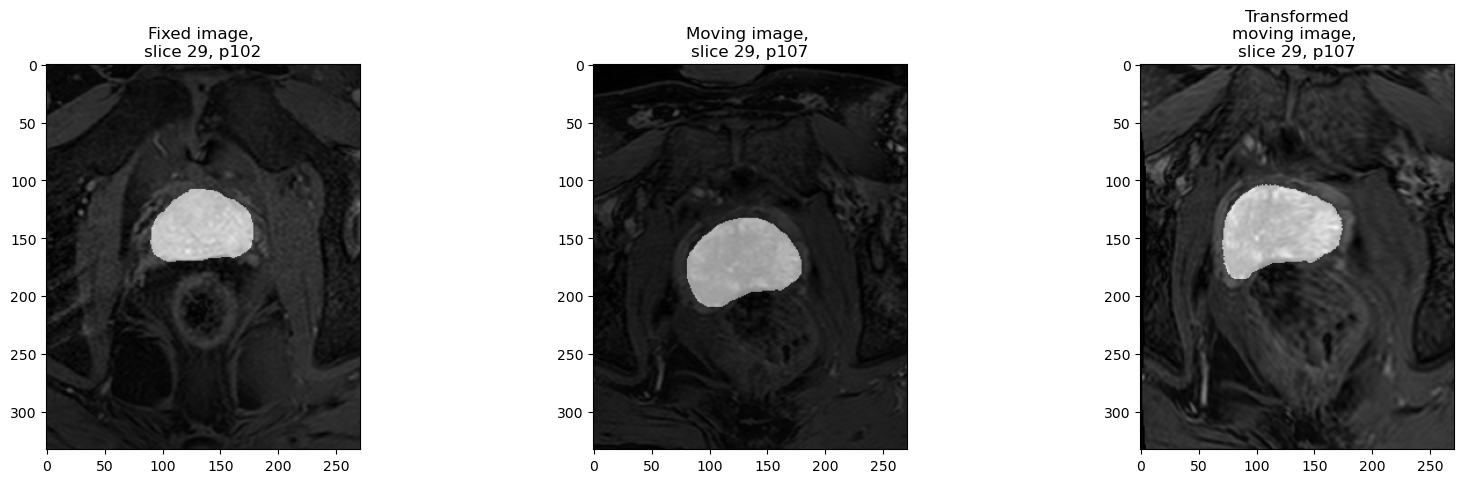

In [25]:
overlay_mask(patient_fixed, patient_moving, slice_fixed, slice_moving)

In [26]:
# Would it be better to overlay the transformed mask on the fixed image, to see how well the transformation went???

## Evaluation metrics

In [32]:
# Calculate DICE score
def diceFunction(im1, im2):
    '''
    Compute the dice score between two input images or volumes. Note that we use a smoothing factor of 1.
    :param im1: Image 1
    :param im2: Image 2
    :return: Dice score
    '''
    
    readable_im1 = imageio.imread(im1)
    readable_im2 = imageio.imread(im2)
    
    im1 = np.asarray(readable_im1).astype(bool)
    im2 = np.asarray(readable_im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return (2. * intersection.sum() + 1 ) / (im1.sum() + im2.sum() + 1)

In [33]:
path_fixed_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)
path_moving_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, slice_moving)

diceFunction(path_fixed_mask, path_moving_mask)

0.47416382936110557

In [41]:
# Compute Hausdorff distances (and other metrics)

def computeQualityMeasures(im_pred, im_truth):
    """
    Computes multiple image registration evaluation measures, including dice score and Hausdorff distances.
    We can decide ourselves which ones we want.
    
    input:
    -im_pred: The predicted segmentation
    -im_truth: The ground truth
    
    output:
    dictionary containing:
    -average Hausdorff distance
    -maximum Hausdorff distance
    -95% Hausdorff distance
    (-dice score)
    (-volume similarity)
    (-false negative rate)
    (-false positive rate)
    (-mean surface distance)
    (-median surface distance)
    (-standard deviation surface distance)
    (-maximum surface distance)
    """
    readable_pred = imageio.imread(im_pred)
    readable_truth = imageio.imread(im_truth)
    
    quality=dict()
    labelPred=sitk.GetImageFromArray(readable_pred, isVector=False)
    labelTrue=sitk.GetImageFromArray(readable_truth, isVector=False)
    
    #Hausdorff Distance
    hausdorffcomputer=sitk.HausdorffDistanceImageFilter()
    hausdorffcomputer.Execute(labelTrue>0.5,labelPred>0.5)
    quality["avgHausdorff"]=hausdorffcomputer.GetAverageHausdorffDistance()
    quality["Hausdorff"]=hausdorffcomputer.GetHausdorffDistance()

    
    ##Dice,Jaccard,Volume Similarity..
    #dicecomputer.Execute(labelTrue>0.5,labelPred>0.5)
    #quality["dice"]=dicecomputer.GetDiceCoefficient()
    #quality["volume_similarity"]=dicecomputer.GetVolumeSimilarity()
    #quality["false_negative"]=dicecomputer.GetFalseNegativeError()
    #quality["false_positive"]=dicecomputer.GetFalsePositiveError()
    
    #Surface distance measures
    label = 1
    ref_distance_map=sitk.Abs(sitk.SignedMaurerDistanceMap(labelTrue>0.5,squaredDistance=False))
    ref_surface=sitk.LabelContour(labelTrue>0.5)
    statistics_image_filter=sitk.StatisticsImageFilter()
    statistics_image_filter.Execute(labelTrue>0.5)
    num_ref_surface_pixels=int(statistics_image_filter.GetSum())

    seg_distance_map=sitk.Abs(sitk.SignedMaurerDistanceMap(labelPred>0.5,squaredDistance=False))
    seg_surface=sitk.LabelContour(labelPred>0.5)
    seg2ref_distance_map=ref_distance_map*sitk.Cast(seg_surface,sitk.sitkFloat32)
    ref2seg_distance_map=seg_distance_map*sitk.Cast(ref_surface,sitk.sitkFloat32)
    
    statistics_image_filter.Execute(labelPred>0.5)
    num_seg_surface_pixels=int(statistics_image_filter.GetSum())

    seg2ref_distance_map_arr=sitk.GetArrayViewFromImage(seg2ref_distance_map)
    seg2ref_distances=list(seg2ref_distance_map_arr[seg2ref_distance_map_arr!=0])
    seg2ref_distances=seg2ref_distances+list(np.zeros(num_seg_surface_pixels-len(seg2ref_distances)))
    ref2seg_distance_map_arr=sitk.GetArrayViewFromImage(ref2seg_distance_map)
    ref2seg_distances=list(ref2seg_distance_map_arr[ref2seg_distance_map_arr!=0])
    ref2seg_distances=ref2seg_distances+list(np.zeros(num_ref_surface_pixels-len(ref2seg_distances)))

    all_surface_distances=seg2ref_distances+ref2seg_distances
    #quality["mean_surface_distance"]=np.mean(all_surface_distances)
    #quality["median_surface_distance"]=np.median(all_surface_distances)
    #quality["std_surface_distance"]=np.std(all_surface_distances)
    #quality["max_surface_distance"]=np.max(all_surface_distances)
    
    
    ### Find the distances to surface points of the contour.  Calculate in both directions         
    dist_seg = sitk.GetArrayViewFromImage(seg_distance_map)[sitk.GetArrayViewFromImage(ref_surface)==1]
    dist_ref = sitk.GetArrayViewFromImage(ref_distance_map)[sitk.GetArrayViewFromImage(seg_surface)==1]


    ### Find the 95% Distance for each direction and average        
    quality['hausdorff_95']= (np.percentile(dist_ref, 95) + np.percentile(dist_seg, 95)) / 2.0

    return quality

In [42]:
path_fixed_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_fixed, patient_fixed, slice_fixed)
path_moving_mask = filepath_data+ '\{}\mask_{}_slice{}.mhd'.format(patient_moving, patient_moving, slice_moving)

computeQualityMeasures(path_fixed_mask, path_moving_mask)

{'avgHausdorff': 7.208621136411615,
 'Hausdorff': 39.45883931389772,
 'hausdorff_95': 33.617332458496094}